In [6]:
import warnings
warnings.filterwarnings('ignore')
import rasterio as rio
import pandas as pd
import numpy as np
import netCDF4 as nc
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline
import os

In [7]:
data_base = r'./hx_30m'

files_arr = ['slope_hx.tif',
 'aspect_hx.tif',
 'plane_cur_hx.tif',
 'profile_cur_hx.tif',
 'R_hx.tif',
 'RI_hx.tif',
 'TPI_hx.tif',
 'TRI_hx.tif',
 'NDVI_hx.tif',
 'TWI_hx.tif',
 'STI_hx.tif',
 'SPI_hx.tif',
 'nj_land_cover_hx.tif',
 'Rn_hx.tif'] # (287, 212)

impervious_data = 'nj_impervious_pro_hx.tif' # (284, 210)
soil_data = 'soil_type_hx.tif' # (305, 229)
dem_data = 'dem.tif' # (286, 211)

In [8]:
start_num_row, end_num_row = 0, 284
start_num_col, end_num_col = 0, 210

wd_threshold = 9  # Unit：mm
label = 'wd'
rain_all_len = 33
rain_len = 27
data_len = (rain_all_len - rain_len + 1)

# 2. generate rainfall series
rain = nc.Dataset(data_base + '/njhx/njhx30.nc')
print("rain['rainfall_depth'].shape:", rain['rainfall_depth'].shape)
rainfall = rain['rainfall_depth'][:rain_all_len] # index 0 means that the first moment rather than 0 moment
print('rainfall.shape:', rainfall.shape)


def generate_series(data, start_index=None, len_series=None):
    """
        len_series: number of series
    """
    if start_index is None:
        raise ValueError('start_index is None')
    if len_series is None:
        raise ValueError('len_series is None')
    arr = []
    for i in range(start_index, len_series):
        arr.append(data[i][:-2, :-1][start_num_row:end_num_row, start_num_col:end_num_col].reshape(-1))
    return np.asarray(arr)

rain_arr = generate_series(rainfall, 0, rain_len)
for i in range(rain_len, rain_all_len):
    d = generate_series(rainfall, i-rain_len+1, i+1) # The nc file index starts at 1
    rain_arr = np.concatenate((rain_arr, d), axis=1)
rain_arr.shape

rain['rainfall_depth'].shape: (96, 286, 211)
rainfall.shape: (33, 286, 211)


(27, 417480)

(array([ 0,  1,  2,  3,  4,  5,  6,  7, 11, 12, 13, 14, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], dtype=int64),)

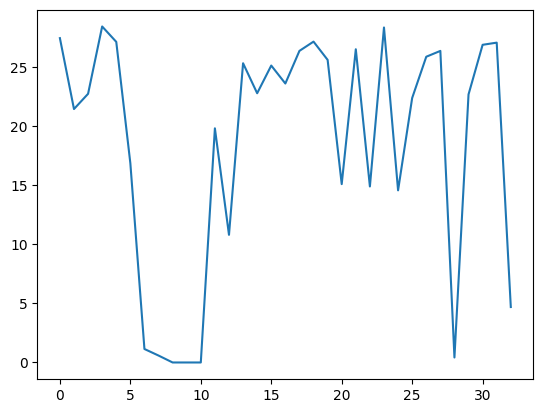

In [9]:
vvv = []
for i in range(rain_all_len):
    vvv.append(max(rainfall[i].reshape(-1)))

import matplotlib.pyplot as plt
plt.plot(vvv)
np.nonzero(vvv)

In [10]:
neigh_rain = [] # Neighborhood point data
neigh_index_for_rain = []  # Get index for other data to extract data
neigh_index_for_other = []
range_num_row = end_num_row - start_num_row
range_num_col = end_num_col - start_num_col

def read_wd_auxiliary(wd_path, s_number, wd_len):
    """
        s_number: start to read from s_number th position (start index is 0)
        wd_len: number of wd results
    """
    wd_arr = []
    for i in range(s_number, wd_len):  # wd000s_number-wd0048
        index = '0' + str(i) if i <10 else str(i)
        wds = rio.open(wd_path.format(index)).read(1)[:-2,:-1][start_num_row:end_num_row, start_num_col:end_num_col].flatten()  # 286, 211 -> 284, 210
        wd_arr.extend(wds)
    return np.asarray(wd_arr)

def read_raster(raster_path):
    # read raster data
    raster = rio.open(raster_path).read(1)[:-3, :-2][start_num_row:end_num_row, start_num_col:end_num_col]  # 287, 212 -> 284, 210
    return raster

def read_impervious(raster_path):
    # read raster data
    raster = rio.open(raster_path).read(1)[start_num_row:end_num_row, start_num_col:end_num_col]
    return raster

def read_dem(raster_path):
    # read raster data
    raster = rio.open(raster_path).read(1)[:-2,:-1][start_num_row:end_num_row, start_num_col:end_num_col] # 286, 211 -> 284, 210
    return raster

def read_soil(raster_path):
    # read raster data
    raster = rio.open(raster_path).read(1)[:-21, :-19][start_num_row:end_num_row, start_num_col:end_num_col] # 305, 229 -> 284, 210
    return raster

# According to the current data, we obtained the rules of neighborhood data. A point with a neighborhood must satisfy the existence of 
# 8 surrounding points. Take 100*100 as an example, the interval that an eight-connected point needs to satisfy is 
# （102-199, 202-299，..., 9802-9899, 10102-10199, ..., 19802-19899）, 计算索引时需要-1
up_rain, down_rain, left_rain, right_rain, up_left_rain, up_right_rain, down_left_rain, down_right_rain = [], [], [], [], [], [], [], []

for j in range(data_len):
    for k in range(1, range_num_row - 1):
        for i in range(1, range_num_col - 1):
            z = i + k * range_num_col + range_num_row * range_num_col * j
            if j == 0:
                neigh_index_for_other.append(z)
            neigh_index_for_rain.append(z)
            neigh_rain.append(rain_arr[:, z])
            up_rain.append(rain_arr[:, z-range_num_col].sum())
            down_rain.append(rain_arr[:, z+range_num_col].sum())
            left_rain.append(rain_arr[:, z-1].sum())
            right_rain.append(rain_arr[:, z+1].sum())
            up_left_rain.append(rain_arr[:, z-range_num_col-1].sum())
            up_right_rain.append(rain_arr[:, z-range_num_col+1].sum())
            down_left_rain.append(rain_arr[:, z+range_num_col-1].sum())
            down_right_rain.append(rain_arr[:, z+range_num_col+1].sum())

var_rain_arr = [up_rain, down_rain, left_rain, right_rain, up_left_rain, up_right_rain, down_left_rain, down_right_rain]
del up_rain; del down_rain; del left_rain; del right_rain; del up_left_rain; del up_right_rain; del down_left_rain; del down_right_rain
print(f'neigh_rain: {len(neigh_rain)}')
neigh_rain = np.asarray(neigh_rain).T

dem = read_dem(os.path.join(data_base, dem_data)).flatten()
# Extract the neighborhood information of the input data index dem used in the first step training
up_dem, down_dem, left_dem, right_dem, up_left_dem, up_right_dem, down_left_dem, down_right_dem = [], [], [], [], [], [], [], []
neigh_dem = [] # Neighborhood point data
for k in range(1, range_num_row - 1):
    for i in range(1, range_num_col - 1):
        z = i + k * range_num_col
        up_dem.append(dem[z-range_num_col])
        down_dem.append(dem[z+range_num_col])
        left_dem.append(dem[z-1])
        right_dem.append(dem[z+1])
        up_left_dem.append(dem[z-range_num_col-1])
        up_right_dem.append(dem[z-range_num_col+1])
        down_left_dem.append(dem[z+range_num_col-1])
        down_right_dem.append(dem[z+range_num_col+1])

var_dem_arr = [up_dem, down_dem, left_dem, right_dem, up_left_dem, up_right_dem, down_left_dem, down_right_dem]
del up_dem; del down_dem; del left_dem; del right_dem; del up_left_dem; del up_right_dem; del down_left_dem; del down_right_dem
neigh_dem = dem[neigh_index_for_other]
print(f'neigh_dem: {len(neigh_dem)}')
wd_path =  data_base + '/njhx/rain/result-00{}.wd'
factors = []
wd = read_wd_auxiliary(wd_path, rain_len-1, rain_all_len)  # remove wd0000 results
wd = wd[neigh_index_for_rain]
data_f = pd.DataFrame(np.asarray(wd)*1000, columns=['wd'])    # meter is converted to centimeter
data_f['dem'] = np.tile(neigh_dem, data_len)

for i in range(rain_len):
    data_f['rainfall_' + str(i)] = neigh_rain[i]  
del neigh_rain
for i in range(8): # The order is up, down, left, up, right, up, left, down, right
    data_f['neigh_dem_'+str(i)] = np.tile(var_dem_arr[i], data_len)
    data_f['neigh_rain_'+str(i)] = var_rain_arr[i]
del var_dem_arr
del var_rain_arr

for f in files_arr:
    factors.append(read_raster(os.path.join(data_base, f)).flatten()[neigh_index_for_other])

factors.append(read_impervious(os.path.join(data_base, impervious_data)).flatten()[neigh_index_for_other])
files_arr.append(impervious_data)

factors.append(read_soil(os.path.join(data_base, soil_data)).flatten()[neigh_index_for_other])
files_arr.append(soil_data)
for i, f in enumerate(factors):
    data_f[files_arr[i].split('.')[0]] = np.tile(factors[i], data_len)
data_f

neigh_rain: 410592
neigh_dem: 58656


,wd,dem,rainfall_0,rainfall_1,rainfall_2,rainfall_3,rainfall_4,rainfall_5,rainfall_6,rainfall_7,...,TPI_hx,TRI_hx,NDVI_hx,TWI_hx,STI_hx,SPI_hx,nj_land_cover_hx,Rn_hx,nj_impervious_pro_hx,soil_type_hx
0,0.0,-3.402823e+38,0.378474,2.121618,0.0,0.000000,0.0,0.512509,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
1,0.0,-3.402823e+38,0.378865,2.703539,0.0,7.083300,0.0,0.528151,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
2,0.0,-3.402823e+38,0.379308,3.062983,0.0,7.377655,0.0,0.543990,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
3,0.0,-3.402823e+38,0.379799,3.269711,0.0,7.860261,0.0,0.562568,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
4,0.0,-3.402823e+38,0.380327,3.234257,0.0,8.581301,0.0,0.574647,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410587,0.0,-3.402823e+38,0.576104,0.000000,0.0,0.000000,0.0,0.000000,0.0,8.230949,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
410588,0.0,-3.402823e+38,0.554480,0.000000,0.0,0.000000,0.0,0.000000,0.0,8.072703,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
410589,0.0,-3.402823e+38,0.551277,0.000000,0.0,0.000000,0.0,0.000000,0.0,7.914641,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
410590,0.0,-3.402823e+38,0.547605,0.000000,0.0,0.000000,0.0,0.000000,0.0,7.922095,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535


In [11]:
data_f1 = data_f.drop_duplicates(inplace=False)
data_f_norepeat = data_f1.query('dem > 0 & neigh_dem_0>0& neigh_dem_1>0& neigh_dem_2>0& neigh_dem_3>0 \
                                        & neigh_dem_4>0& neigh_dem_5>0& neigh_dem_6>0& neigh_dem_7>0')

data_f_filter = data_f_norepeat.query('wd > ' + str(wd_threshold))

first_step_factors = ['wd', 'dem', 'neigh_dem_0',
       'neigh_rain_0', 'neigh_dem_1', 'neigh_rain_1', 'neigh_dem_2',
       'neigh_rain_2', 'neigh_dem_3', 'neigh_rain_3', 'neigh_dem_4',
       'neigh_rain_4', 'neigh_dem_5', 'neigh_rain_5', 'neigh_dem_6',
       'neigh_rain_6', 'neigh_dem_7', 'neigh_rain_7']

def MAD_detect(data_f):
    df_wd = data_f['wd']
    Low = df_wd.mean() - 3*df_wd.std()
    Up = df_wd.mean() + 3*df_wd.std()
    return data_f[(df_wd>=Low)&(df_wd<=Up)]

data_final1 = MAD_detect(data_f_filter)

for i in range(rain_len):
    first_step_factors.append('rainfall_'+str(i))

index = data_final1[(data_final1['rainfall_'+str(rain_len-1)]==0)].index
data_final = data_final1.drop(index)
data_final_first = data_final[first_step_factors]
wd_index = data_final_first.index.tolist()
print('data_final.shape: ', data_final_first.shape)

data_final.shape:  (11951, 45)


In [12]:
from autogluon.tabular import TabularPredictor

def split_dataset_notin_val(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

# import Auto-Flood model

y_true = data_final['wd']

train_data, test_data = split_dataset_notin_val(data_final_first, test_ratio=0.3)
train_data_first, test_data_first = train_data[first_step_factors], test_data[first_step_factors]

# Predicted label
label = 'wd'
# Model save file name
save_path = 'AutogluonModels/model_gos'
# Build a prediction model, verbosity(0 to 4), default to 2 is fine
predictor = TabularPredictor(problem_type='regression', label=label, path=save_path, verbosity=0)
predictor.fit(train_data_first, presets='best_quality', num_bag_folds=5, num_bag_sets=1, num_stack_levels=1) # 后面可以尝试使用num_bag_folds 5-10进行不确定性测试

In [13]:
res = predictor.evaluate(test_data_first, silent=True)
res

{'root_mean_squared_error': -23.341989517211914,
 'mean_squared_error': -544.8484497070312,
 'mean_absolute_error': -9.664365768432617,
 'r2': 0.6472778209567005,
 'pearsonr': 0.8056236141076674,
 'median_absolute_error': -1.045365810394287}

In [14]:
save_path = 'AutogluonModels/model_gos'
predictor = TabularPredictor.load(save_path)
result = predictor.predict(data_final_first.drop(columns=[label]))

In [15]:
wd_class_index = []
data_len1 = 282 * 208
wd_index_copy = wd_index.copy()
for i in range(1, data_len+1):
    a = []
    while(True):
        if len(wd_index_copy)!=0 and wd_index_copy[0]//(data_len1*i) == 0:
            a.append(wd_index_copy[0])
            wd_index_copy.pop(0)
        else:
            break
    print(a)
    wd_class_index.append(a)

[3643, 3644, 3852, 3853, 4060, 4061, 4062, 4268, 4269, 4270, 4273, 4475, 4476, 4477, 4478, 4482, 4683, 4684, 4685, 4889, 4890, 4891, 4892, 4893, 5097, 5098, 5099, 5100, 5101, 5112, 5113, 5306, 5307, 5308, 5309, 5322, 5513, 5514, 5515, 5516, 5722, 5724, 5741, 5932, 6115, 6116, 6117, 6140, 6159, 6323, 6324, 6325, 6326, 6348, 6531, 6532, 6533, 6534, 6556, 6577, 6739, 6740, 6741, 6742, 6764, 6780, 6781, 6947, 6948, 6949, 6950, 6951, 6994, 7154, 7155, 7156, 7157, 7158, 7159, 7160, 7161, 7181, 7202, 7203, 7362, 7363, 7364, 7365, 7366, 7367, 7368, 7369, 7389, 7407, 7408, 7409, 7410, 7411, 7412, 7570, 7571, 7572, 7573, 7574, 7575, 7576, 7577, 7597, 7615, 7616, 7617, 7618, 7619, 7620, 7778, 7779, 7780, 7781, 7782, 7783, 7784, 7785, 7805, 7823, 7824, 7825, 7829, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8402, 8403, 8405, 8406, 8407, 8408, 8409, 8410, 8411, 8610, 8611, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8619, 8818, 8819, 8820, 8821, 882

In [16]:
data_f.to_csv('data_f_test.csv')

In [17]:
data_f_result = data_f.copy()
for i in range(len(wd_class_index)):
    data_f_result.loc[wd_class_index[i], 'wd'] = result[wd_class_index[i]]

In [18]:
data_f_result

,wd,dem,rainfall_0,rainfall_1,rainfall_2,rainfall_3,rainfall_4,rainfall_5,rainfall_6,rainfall_7,...,TPI_hx,TRI_hx,NDVI_hx,TWI_hx,STI_hx,SPI_hx,nj_land_cover_hx,Rn_hx,nj_impervious_pro_hx,soil_type_hx
0,0.0,-3.402823e+38,0.378474,2.121618,0.0,0.000000,0.0,0.512509,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
1,0.0,-3.402823e+38,0.378865,2.703539,0.0,7.083300,0.0,0.528151,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
2,0.0,-3.402823e+38,0.379308,3.062983,0.0,7.377655,0.0,0.543990,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
3,0.0,-3.402823e+38,0.379799,3.269711,0.0,7.860261,0.0,0.562568,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
4,0.0,-3.402823e+38,0.380327,3.234257,0.0,8.581301,0.0,0.574647,0.0,0.000000,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410587,0.0,-3.402823e+38,0.576104,0.000000,0.0,0.000000,0.0,0.000000,0.0,8.230949,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
410588,0.0,-3.402823e+38,0.554480,0.000000,0.0,0.000000,0.0,0.000000,0.0,8.072703,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
410589,0.0,-3.402823e+38,0.551277,0.000000,0.0,0.000000,0.0,0.000000,0.0,7.914641,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535
410590,0.0,-3.402823e+38,0.547605,0.000000,0.0,0.000000,0.0,0.000000,0.0,7.922095,...,-3.402823e+38,-3.402823e+38,-32768,-3.402823e+38,-3.402823e+38,-3.402823e+38,-128,-3.402823e+38,3,65535


In [19]:
predictor.leaderboard(test_data_first).to_csv('leaderboard.csv')

In [20]:
data_final['first_second_wd'] = result

[   1    2    3 ... 3524 3525 3526] x_len


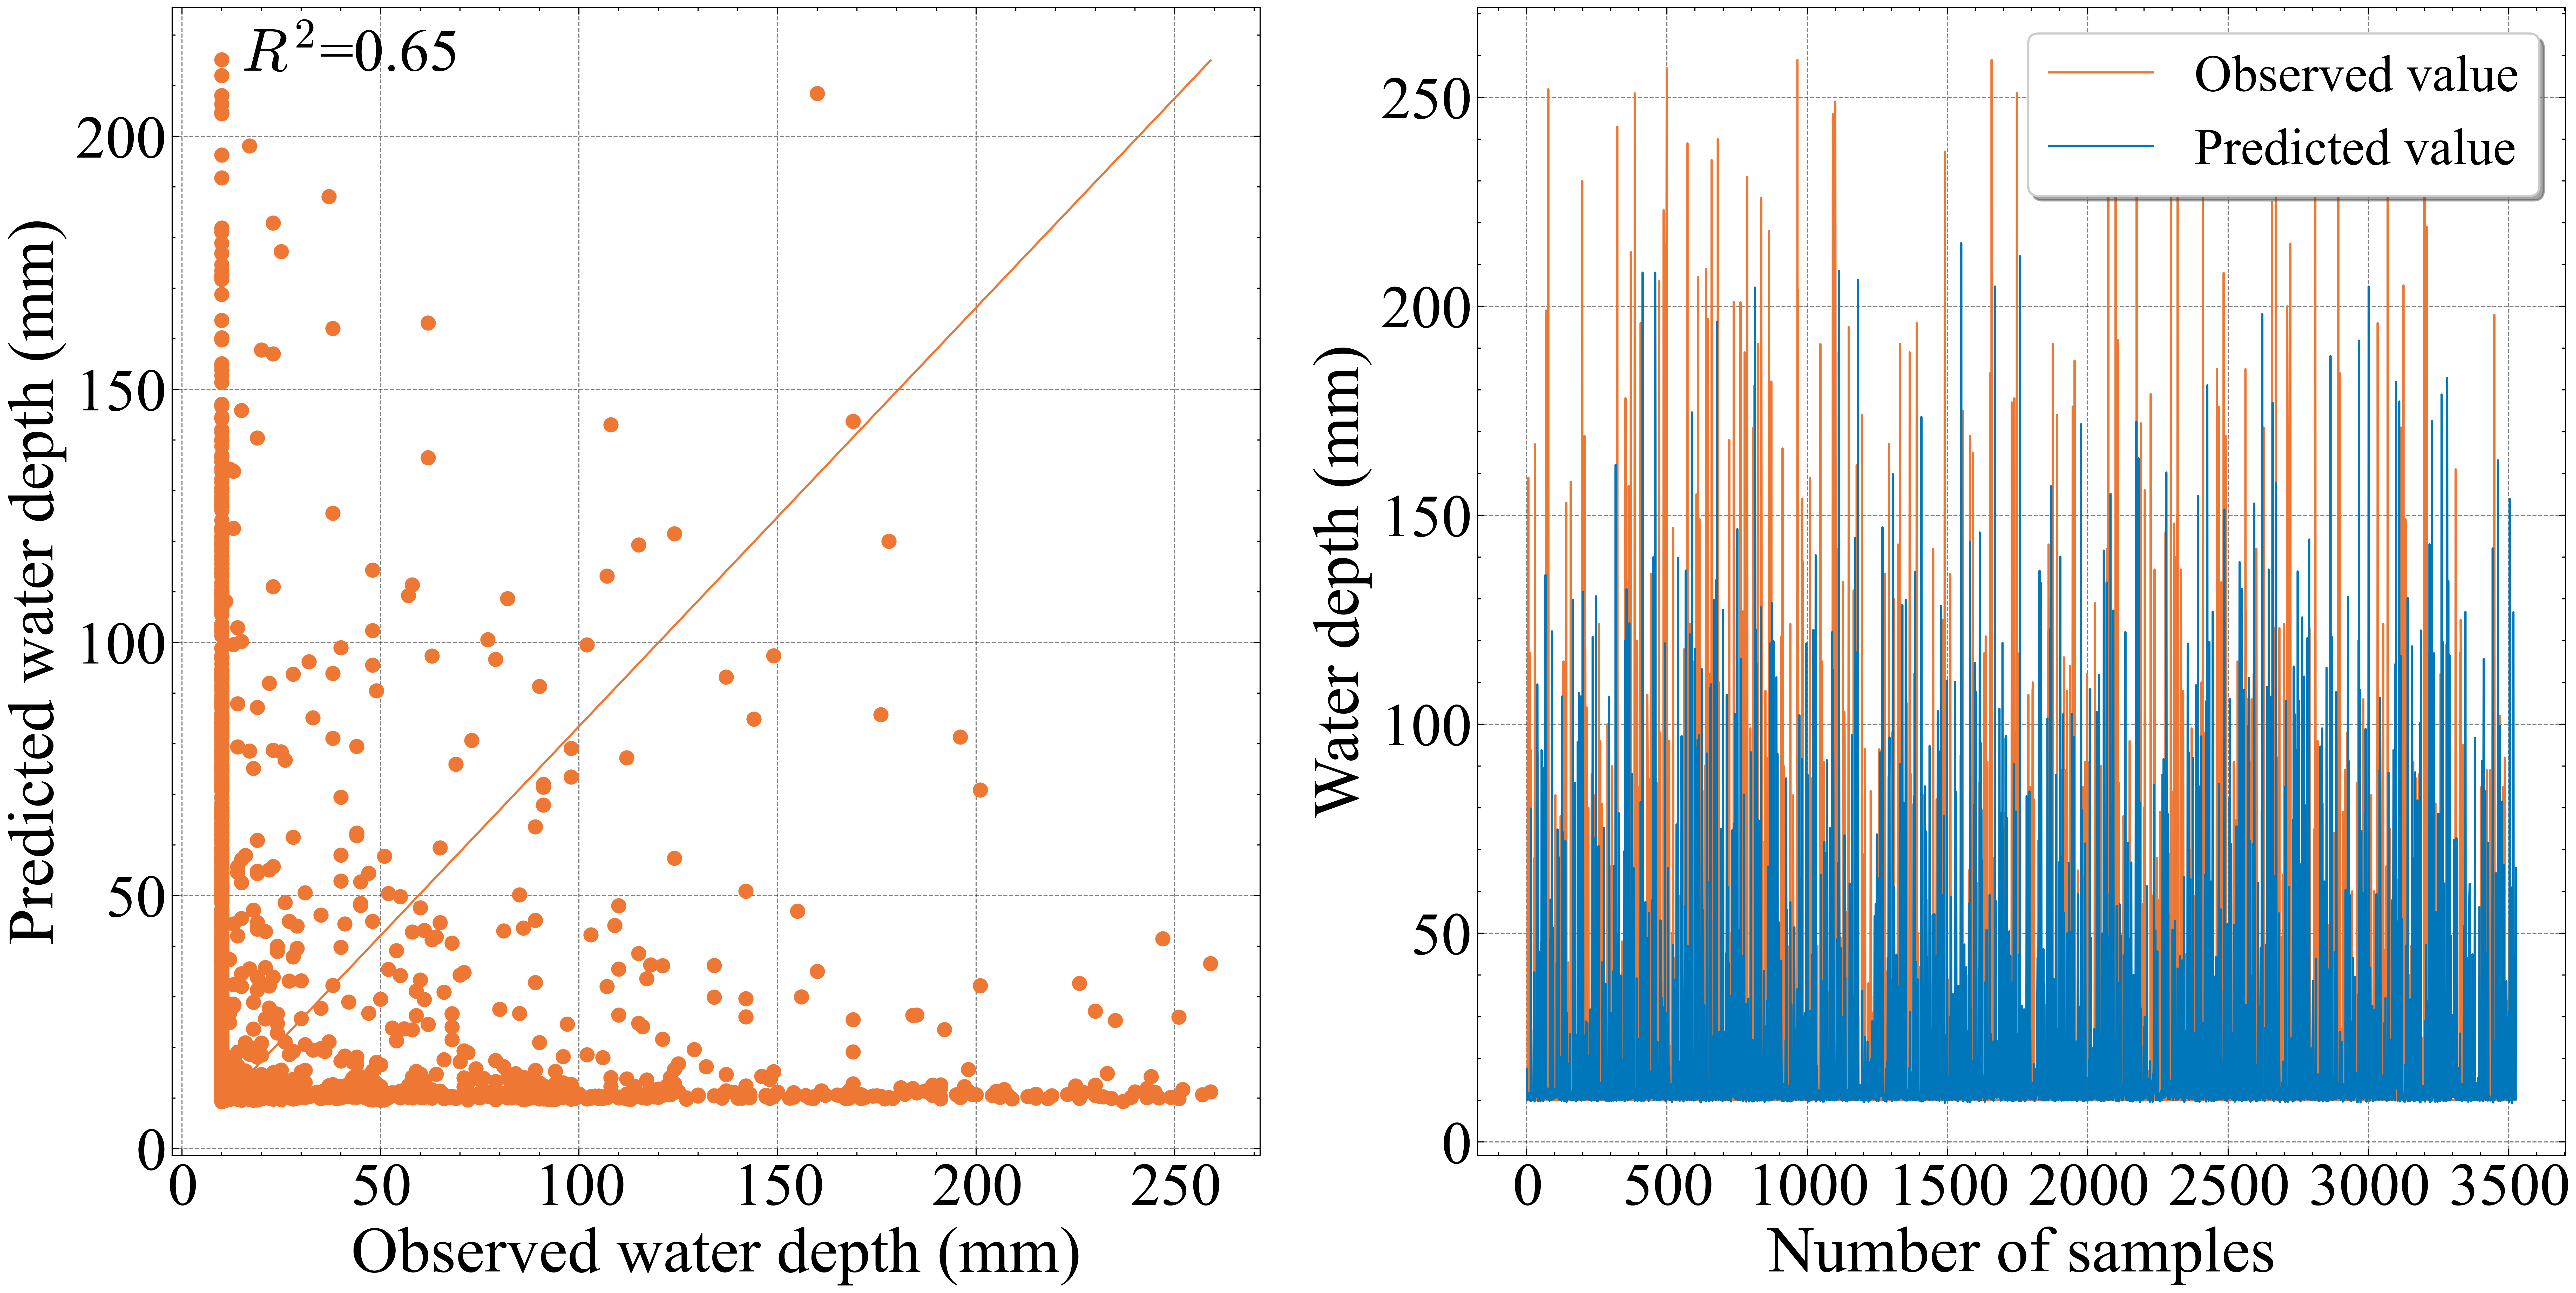

In [29]:
import scienceplots
from matplotlib import rcParams
import matplotlib.ticker as mtick
import numpy as np
import warnings
warnings.filterwarnings('ignore')

fs = 32
fonrfamily = 'Times New Roman'
config = {
    "font.family":fonrfamily,
    # "font.size": fs,
    "mathtext.fontset":'stix',
    "font.serif": [fonrfamily],
}


rcParams.update(config)
# Fixed an issue where negative signs could not be displayed
plt.rcParams['axes.unicode_minus'] =False

# num = 1600
num = len(test_data_first['wd'])
y1, y2 = np.random.choice(test_data_first['wd'], size=num, replace=False), np.random.choice(predictor.predict(test_data_first.drop(columns=[label])), size=num, replace=False)

x_len = np.arange(1, len(y1)+1)
print(x_len, 'x_len')
with plt.style.context(['science', 'ieee', 'vibrant', 'grid', 'no-latex']): 
    plt.figure(figsize =(16, 8))
    plt.subplot(1, 2, 1)
    plt.tight_layout(pad=2)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None, wspace=0.2)
    plt.scatter(y1, y2)
    x_min, x_max, y_min, y_max = int(y1.min()), int(y1.max()), int(y2.min()), int(y2.max())
    plt.plot(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.xlabel("Observed water depth (mm)", fontsize=fs-2, fontproperties=fonrfamily)
    plt.ylabel("Predicted water depth (mm)", fontsize=fs-2, fontproperties=fonrfamily)
    plt.yticks(fontproperties = fonrfamily, size = fs-4)
    plt.xticks(fontproperties = fonrfamily, size = fs-4)
    plt.text(x_min+5, y_max-2, '$R^2$={:.2f}'.format(res['r2']), fontproperties=fonrfamily, size=fs-4)
    plt.subplot(1, 2, 2)
    plt.xlabel("Number of samples", fontsize=fs-2, fontproperties=fonrfamily)
    plt.ylabel("Water depth (mm)", fontsize=fs-2, fontproperties=fonrfamily)
    plt.yticks(fontproperties = fonrfamily, size = fs-4)
    plt.xticks(range(0, len(y1), 500), fontproperties = fonrfamily, size = fs-4)
    plt.plot(x_len, y1, label='Observed value')
    plt.plot(x_len, y2, label='Predicted value')
    plt.legend(loc='best', shadow = True, fancybox= True, prop={'family': fonrfamily, 'size':fs-8})

    plt.savefig('true_pred_first.jpg', dpi=300, bbox_inches='tight')
    plt.show()

In [25]:
data_final.to_csv('data_final_test.csv')